## Import Libraries

In [1]:
# Import necessary libraries for numerical operations and plotting
import numpy as np
import matplotlib.pyplot as plt

# Import PyTorch for building neural networks and handling tensors
import torch
import torch.nn as nn  # Import PyTorch's neural network module

# Import DataLoader and TensorDataset for batching and handling datasets
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

# Import Path from pathlib for handling file paths
from pathlib import Path

# Import pandas for data manipulation and analysis
import pandas as pd


# Load the training and test datasets from CSV files

In [ ]:
data_folder = Path('C:/Users/Benyamin/OneDrive - University of Portsmouth/Documents/Python Scripts/DAE Solver/PyBamm/Python/DATA')

In [4]:
dfTrain = pd.read_csv(data_folder/'Data.csv')
dfTest = pd.read_csv(data_folder/'TestData.csv')
print(dfTest.head())

   Unnamed: 0        V1        V2        V3        V4        V5        V6  \
0           0  4.032505  4.028532  4.023916  4.018527  4.013486  4.010106   
1           1  4.032505  4.025579  4.020376  4.013544  4.009175  4.004167   
2           2  4.032505  4.027561  4.022592  4.018308  4.014575  4.010673   
3           3  4.032505  4.026847  4.021660  4.017033  4.012919  4.009350   
4           4  4.032505  4.026799  4.021484  4.016532  4.011911  4.007591   

         V7        V8        V9  ...     I1791     I1792     I1793     I1794  \
0  4.006899  4.003871  4.001336  ...  5.328128  5.268589  5.187199  5.168915   
1  3.999449  3.996643  3.992216  ...  4.511329  4.530696  4.488538  4.552208   
2  4.007166  4.004274  4.001200  ...  5.115452  5.119470  5.088178  5.051787   
3  4.006145  4.003212  4.000298  ...  5.474872  5.483369  5.471371  5.445421   
4  4.003543  3.999744  3.996174  ...  5.420728  5.424038  5.422906  5.416527   

      I1795     I1796     I1797     I1798     I1799     

# Extract the input features (X_train) from the training data


In [8]:
n = 10000  # Number of data points
T = 1800   # Length of each data sequence
X_train = dfTrain.iloc[:, T+1:2*T+1].values
Xmu = X_train.mean()   # Calculate the mean of X_train
Xsig = X_train.std()   # Calculate the standard deviation of X_train
X_train = np.array((X_train - Xmu) / Xsig)  # Normalize X_train
X_train.shape
# X_train

(10000, 1800)

# Extract the target values (y_train) from the training data


In [9]:
y_train = dfTrain.iloc[:, 1:T+1].values
ymu = y_train.mean()   # Calculate the mean of y_train
ysig = y_train.std()   # Calculate the standard deviation of y_train
y_train = np.array((y_train - ymu) / ysig)  # Normalize y_train
y_train.shape

(10000, 1800)

# Extract the input features (X_test) from the test data


In [10]:
X_test = dfTest.iloc[:, T+1:2*T+1].values
Xmu = X_test.mean()   # Calculate the mean of X_test
Xsig = X_test.std()   # Calculate the standard deviation of X_test
X_test = np.array((X_test - Xmu) / Xsig)  # Normalize X_test
X_test.shape

(1000, 1800)

# Extract the target values (y_test) from the test data


In [11]:
y_test = dfTest.iloc[:, 1:T+1].values
ymu = y_test.mean()   # Calculate the mean of y_test
ysig = y_test.std()   # Calculate the standard deviation of y_test
y_test = np.array((y_test - ymu) / ysig)  # Normalize y_test
y_test.shape

(1000, 1800)

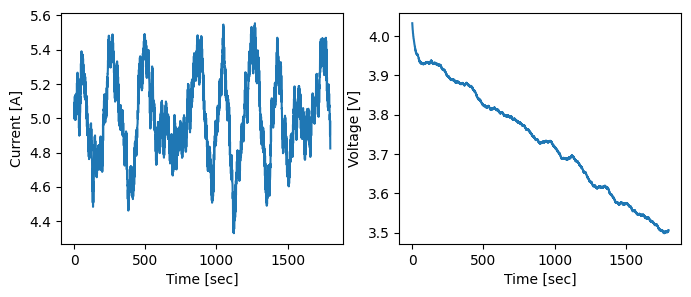

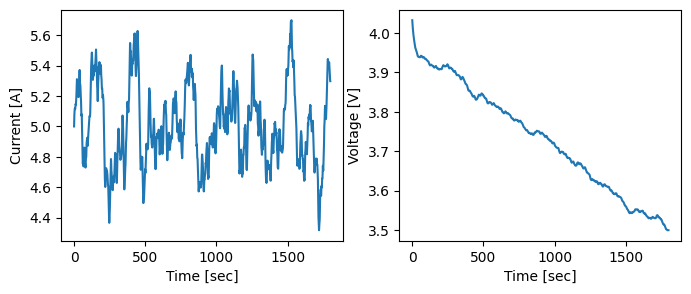

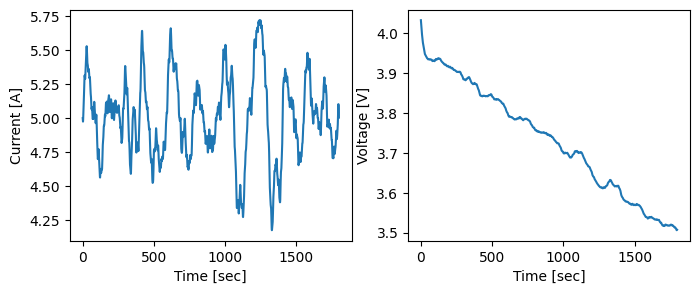

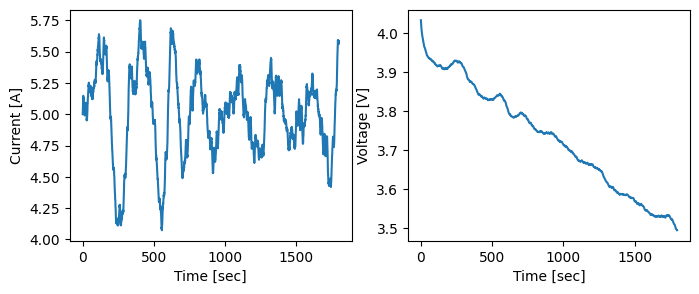

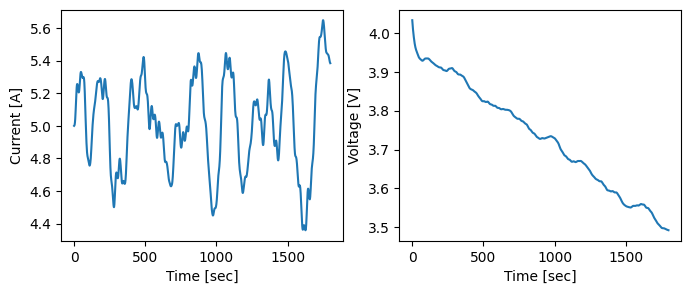

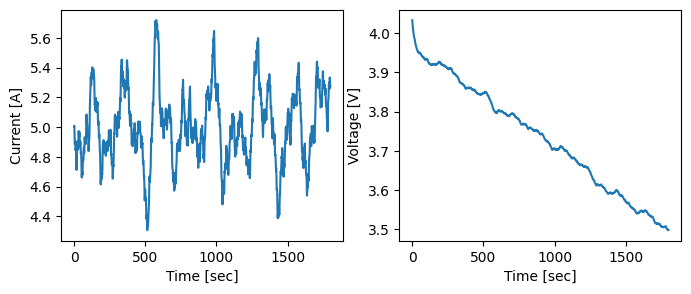

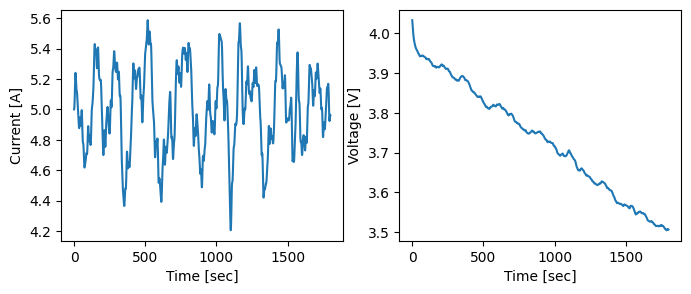

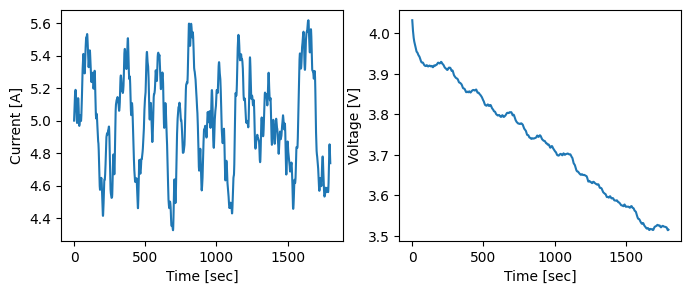

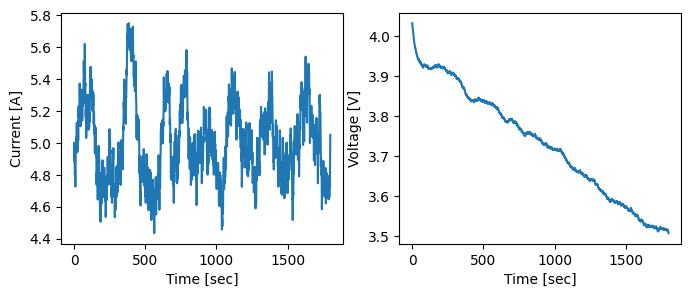

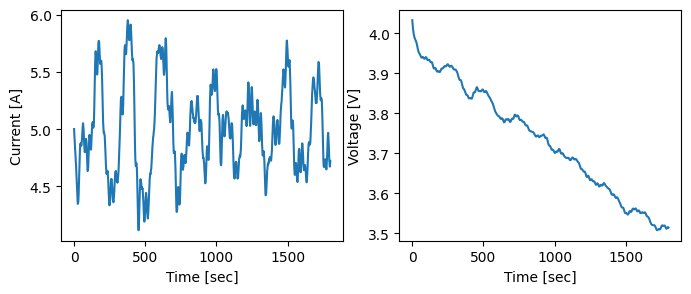

In [16]:
# Generate and plot 10 random samples from the training data
for i in range(10):
    j = np.random.randint(n)
    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    plt.plot(X_train[j]*Xsig+Xmu)   # Plot the input feature (X_train)
    plt.xlabel('Time [sec]')
    plt.ylabel('Current [A]')
    plt.subplot(1,2,2)
    plt.plot(y_train[j]*ysig+ymu)   # Plot the target value (y_train)
    plt.xlabel('Time [sec]')
    plt.ylabel('Voltage [V]')
    plt.show()

In [17]:
cuda=True # Set CUDA flag to True
if not torch.cuda.is_available():
    cuda = False
device = torch.device("cuda" if cuda else "cpu") # Set the device to CUDA if available, otherwise use CPU
print(device)

cpu


In [18]:
X_train_PT = torch.from_numpy(X_train).float()  # Convert X_train to a PyTorch tensor
y_train_PT = torch.from_numpy(y_train).float()  # Convert y_train to a PyTorch tensor
train_ds = TensorDataset(X_train_PT, y_train_PT)  # Create a PyTorch Dataset for training data
batch_size = 1000  # Set the batch size
train_dl = DataLoader(train_ds, batch_size, shuffle=True)  # Create a PyTorch DataLoader for training data

X_test_PT = torch.from_numpy(X_test).float()  # Convert X_test to a PyTorch tensor
y_test_PT = torch.from_numpy(y_test).float()  # Convert y_test to a PyTorch tensor
test_ds = TensorDataset(X_test_PT, y_test_PT)  # Create a PyTorch Dataset for test data
batch_size = 1000  # Set the batch size
test_dl = DataLoader(test_ds, batch_size, shuffle=True)  # Create a PyTorch DataLoader for test data

Neural Network Stracture

In [19]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the first linear layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # Define the second linear layer
        self.layer3 = nn.Linear(hidden_size, output_size)  # Define the third linear layer

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)  # Apply sigmoid activation function
        x = self.layer2(x)
        x = nn.Sigmoid()(x)  # Apply sigmoid activation function
        x = self.layer3(x)
        return x

Hyperparameters

In [20]:
input_size = X_train.shape[1]  # Set the input size based on the shape of X_train
hidden_size = 1000  # Set the size of the hidden layer
output_size = y_train.shape[1]  # Set the output size based on the shape of y_train
model = Model(input_size, hidden_size, output_size)  # Create an instance of the model
loss_fn = nn.MSELoss(reduction='mean')  # Define the loss function (Mean Squared Error)
learning_rate = 0.001  # Set the learning rate
learnRateDropFactor = 0.5
learnRateDropPeriod = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Define the optimizer
model

Model(
  (layer1): Linear(in_features=1800, out_features=1000, bias=True)
  (layer2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer3): Linear(in_features=1000, out_features=1800, bias=True)
)

Training the NN

In [21]:
loss_values = []
lossT_values = []
iteration_values = []
epoch_values = []
No = 0
No_values = []
MSE_values =[]
it = 0
epoch2 = 0

epoch = 102 | MSE = 0.00023583564325235784| Learning Rate =0.0005
epoch = 103 | MSE = 0.0002379250363446772| Learning Rate =0.0005
epoch = 104 | MSE = 0.00023410512949340045| Learning Rate =0.0005
epoch = 105 | MSE = 0.0002318398910574615| Learning Rate =0.0005
epoch = 106 | MSE = 0.0002339792699785903| Learning Rate =0.0005
epoch = 107 | MSE = 0.00023002017405815423| Learning Rate =0.0005
epoch = 108 | MSE = 0.00022661552065983415| Learning Rate =0.0005
epoch = 109 | MSE = 0.00022860766330268234| Learning Rate =0.0005
epoch = 110 | MSE = 0.0002265272632939741| Learning Rate =0.0005
epoch = 111 | MSE = 0.00022721881396137178| Learning Rate =0.0005
epoch = 112 | MSE = 0.0002233483683085069| Learning Rate =0.0005
epoch = 113 | MSE = 0.0002226195065304637| Learning Rate =0.0005
epoch = 114 | MSE = 0.00022422389884013683| Learning Rate =0.0005
epoch = 115 | MSE = 0.00022253628412727267| Learning Rate =0.0005
epoch = 116 | MSE = 0.00022000339231453836| Learning Rate =0.0005
epoch = 117 | MS

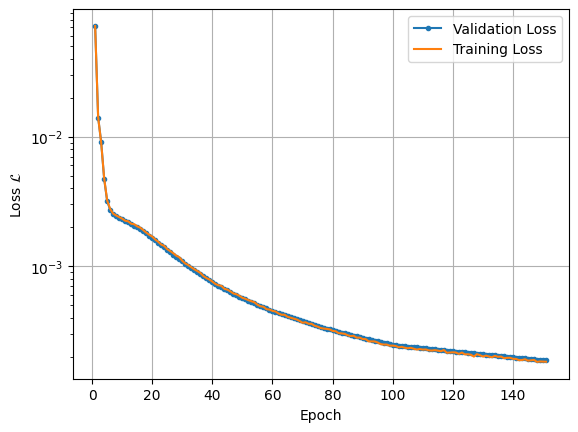

In [26]:
num_epochs = 50  # Set the number of training epochs
loss_hist = [0] * num_epochs  # Initialize a list to store the loss history
accuracy_hist = [0] * num_epochs  # Initialize a list to store the accuracy history
tmp = next(iter(test_dl))

# Training loop
for epoch in range(num_epochs):

    epoch2 +=1
    for x_batch, y_batch in train_dl:
        it +=1
        pred = model(x_batch)  # Perform forward pass
        predT = model(tmp[0])  # Perform inference on the test data
        real = tmp[1]
        loss  = loss_fn(pred, y_batch)  # Calculate the loss
        loss2 = loss_fn(real, predT)  # Calculate the loss
        loss.backward()  # Perform backward pass (calculate gradients)
        optimizer.step()  # Update model parameters
        optimizer.zero_grad()  # Reset gradients to zero
        iteration_values.append(it)
    
    # Adjust the learning rate
    if epoch2 % learnRateDropPeriod == 0:
        learning_rate = learning_rate * learnRateDropFactor
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate
    loss_values.append(loss.item())
    lossT_values.append(loss2.item())
    epoch_values.append(epoch2)

    print(f'epoch = {epoch2} | MSE = {loss_values[-1]}| Learning Rate ={learning_rate}')

plt.semilogy(epoch_values, lossT_values, '-o', label='Validation Loss', markersize=3)
plt.semilogy(epoch_values, loss_values, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss $\mathcal{L}$')
plt.grid(True)
plt.legend()
plt.show()
    

Testing the trained NN

In [ ]:
# Test #################################
tmp = next(iter(test_dl))
pred = model(tmp[0]).detach().numpy()  # Perform inference on the test data
real = tmp[1].detach().numpy()
#plot the result

for i in range(1000):
    No += 1
    if i % 200 == 0:
        plt.figure(figsize=(4, 2))
        plt.plot(pred[i]*ysig+ymu)  # Plot the predicted values
        plt.plot(real[i]*ysig+ymu)  # Plot the ground truth values
        plt.legend(['NN model', 'Test data (DFN model)'])
        plt.xlabel('Time[sec]')
        plt.ylabel('Voltage[V]')
        plt.show()
    MSE_values.append(np.mean((((pred[i]-real[i])*ysig))**2))
    No_values.append(No)
print(f'RMSE = {np.sqrt(np.mean(MSE_values))*1000}mV')

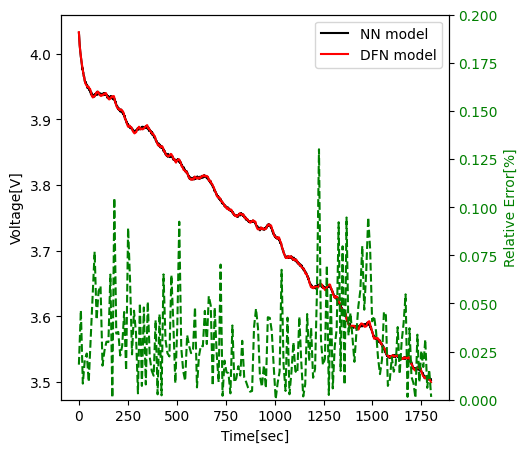

In [80]:
Re = abs(pred[0]-real[0])*ysig/abs(real[0]*ysig+ymu)*100
Ree = []
for i in range(180):
    Ree.append(Re[10 * i])
xnew = np.linspace(0,1800,180)
fig, ax1 = plt.subplots(figsize=(5, 5))
ax1.set_xlabel('Time[sec]')
ax1.set_ylabel('Voltage[V]', color='black')
plot_1 = ax1.plot(pred[0]*ysig+ymu, color='black')
plot_2 = ax1.plot(real[0]*ysig+ymu, color='red')
plt.legend(['NN model', 'DFN model'])
ax1.tick_params(axis='y', labelcolor='black')
# Twin Axes
ax2 = ax1.twinx()
ax2.set_ylabel('Relative Error[%]', color='green')
plot_3 = ax2.plot(xnew, Ree,'--', color='green')
ax2.set_ylim(0, 0.2)
ax2.tick_params(axis='y', labelcolor='green')
plt.show()

In [73]:
# Save the model state
torch.save(model.state_dict(), 'model_weights_MLPnew2.pth')